In [2]:
# !pip uninstall -y flax orbax-checkpoint jax jaxlib \
#     ml-dtypes tf-keras tensorflow tensorflow-cpu tensorflow-text \
#     tensorflow-decision-forests keras keras-hub \
#     chex optax fastai spacy tensorstore numba \
#     umap-learn pynndescent librosa shap cuml-cu12 cudf-cu12 dask-cuda

%pip install -U threadpoolctl joblib
#%pip install --force-reinstall numpy==1.26.4
%pip install --upgrade scikit-learn
%pip install -U imbalanced-learn

%pip install --upgrade --force-reinstall \
    numpy \
    scipy \
    matplotlib \
    seaborn \
    pandas \
    tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.24.4-cp38-cp38-macosx_11_0_arm64.whl.metadata (5.6 kB)
  Using cached scipy-1.10.1-cp38-cp38-macosx_12_0_arm64.whl.metadata (53 kB)
  Using cached matplotlib-3.7.5-cp38-cp38-macosx_11_0_arm64.whl.metadata (5.7 kB)
  Using cached pandas-2.0.3-cp38-cp38-macosx_11_0_arm64.whl.metadata (18 kB)
  Using cached tensorflow-2.13.1-cp38-cp38-macosx_12_0_arm64.whl.metadata (2.6 kB)
  Using cached contourpy-1.1.1-cp38-cp38-macosx_11_0_arm64.whl.metadata (5.9 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp38-cp38-macosx_10_9_universal2.whl.metadata (102 kB)
  Using cached kiwisolver-1.4.7-cp38-cp38-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached pillow-10.4

In [3]:
import importlib, random, os, numpy as np, tensorflow as tf

print("===== VERSIONS =====")
for lib in ("numpy", "pandas", "sklearn", "imblearn",
            "tensorflow", "matplotlib", "seaborn"):
    m = importlib.import_module(lib if lib != "sklearn" else "sklearn")
    print(f"{lib:17s}: {m.__version__}")

print("\n===== TensorFlow devices =====")
print(tf.config.list_physical_devices())   # ← здесь будет только CPU, и это нормально

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
print(f"\nRandom seed set to {SEED}")

===== VERSIONS =====
numpy            : 1.24.3
pandas           : 2.0.3
sklearn          : 1.3.2
imblearn         : 0.12.4
tensorflow       : 2.13.0
matplotlib       : 3.7.5
seaborn          : 0.13.2

===== TensorFlow devices =====
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Random seed set to 42


In [7]:
# === @title Этап 2 (Kaggle API) — Ethereum Fraud Detection ===
# 0. (если делали раньше, шаги с pip и токеном можно пропустить)

# — 0.1 Установка библиотеки kaggle —
%pip install --quiet kaggle

# # — 0.2 Загрузка kaggle.json (один раз за сессию Colab) —
# #    Если токен уже лежит в ~/.kaggle, эту строку можно пропустить.
# from google.colab import files, auth
# import pathlib, io, os, json, pandas as pd

# if not pathlib.Path("~/.kaggle/kaggle.json").expanduser().exists():
#     print("📂 Загрузите kaggle.json ➜")
#     token_file = files.upload()           # откроется диалог
#     if "kaggle.json" not in token_file:
#         raise ValueError("Нужно загрузить файл под именем kaggle.json")
#     pathlib.Path("~/.kaggle").expanduser().mkdir(exist_ok=True)
#     with open(pathlib.Path("~/.kaggle/kaggle.json").expanduser(), "wb") as f:
#         f.write(token_file["kaggle.json"])
#     !chmod 600 ~/.kaggle/kaggle.json
# else:
#     print("🔑 kaggle.json уже настроен")

import os
import json
import pathlib
import pandas as pd
import zipfile
from kaggle.api.kaggle_api_extended import KaggleApi

# 1. Убедимся, что у нас есть файл kaggle.json (с токеном Kaggle)
kaggle_json_path = '../kaggle.json'

if not os.path.exists(kaggle_json_path):
    raise FileNotFoundError("Файл 'kaggle.json' не найден. Пожалуйста, скачайте его с вашего аккаунта Kaggle.")

# 2. Конфигурируем API Kaggle с использованием токена
with open(kaggle_json_path) as f:
    kaggle_json = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_json['username']
os.environ['KAGGLE_KEY'] = kaggle_json['key']

# 3. Инициализируем API
api = KaggleApi()
api.authenticate()

# 1. Скачиваем архив датасета
slug = "vagifa/ethereum-frauddetection-dataset"
print(f"\n⬇️ Скачиваю датасет {slug} ...")
!kaggle datasets download -d {slug} -p ./data --force --quiet

# 2. Распаковываем
print("📦 Распаковываю ...")
!unzip -o ./data/*.zip -d ./data > /dev/null

# 3. Открываем transactions.csv
csv_path = "./data/transactions.csv"
if not os.path.exists(csv_path):
    # fallback: берем первый найденный CSV
    import glob
    found = glob.glob("./data/**/*.csv", recursive=True)
    if not found:
        raise RuntimeError("CSV-файлы не найдены в архиве.")
    csv_path = found[0]
print(f"✅ Нашёл CSV: {csv_path}")

df = pd.read_csv(csv_path)

# 4. Отладочная информация
print("\n===== SHAPE =====")
print(df.shape)            # ожидаем (9840, 49)

print("\n===== HEAD (5 строк) =====")
display(df.head())

print("\n===== Классовое соотношение (isFraud) =====")
if "FLAG" in df.columns:
    display((df["FLAG"].value_counts(normalize=True) * 100).round(2).rename("%"))
else:
    print("Столбец 'FLAG' не найден — проверьте структуру датасета.")

Note: you may need to restart the kernel to use updated packages.

⬇️ Скачиваю датасет vagifa/ethereum-frauddetection-dataset ...
Dataset URL: https://www.kaggle.com/datasets/vagifa/ethereum-frauddetection-dataset
License(s): DbCL-1.0
  0%|                                                | 0.00/923k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 923k/923k [00:00<00:00, 1.88GB/s]
📦 Распаковываю ...
✅ Нашёл CSV: ./data/transaction_dataset.csv

===== SHAPE =====
(9841, 51)

===== HEAD (5 строк) =====


,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS



===== Классовое соотношение (isFraud) =====


FLAG
0    77.86
1    22.14
Name: %, dtype: float64

In [8]:
df.drop(columns=["Unnamed: 0", "Index"], inplace=True, errors="ignore")
df['FLAG'].value_counts(normalize=True)

FLAG
0    0.778579
1    0.221421
Name: proportion, dtype: float64

==> Shape после удаления служебных колонок: (9841, 49)

===== ТОП-10 столбцов по числу NaN =====


 ERC20 most sent token type     2697
 ERC20_most_rec_token_type       871
 ERC20 max val rec               829
 ERC20 uniq rec token name       829
 ERC20 uniq sent token name      829
 ERC20 avg val sent contract     829
 ERC20 max val sent contract     829
 ERC20 min val sent contract     829
 ERC20 avg val sent              829
 ERC20 max val sent              829
dtype: int64

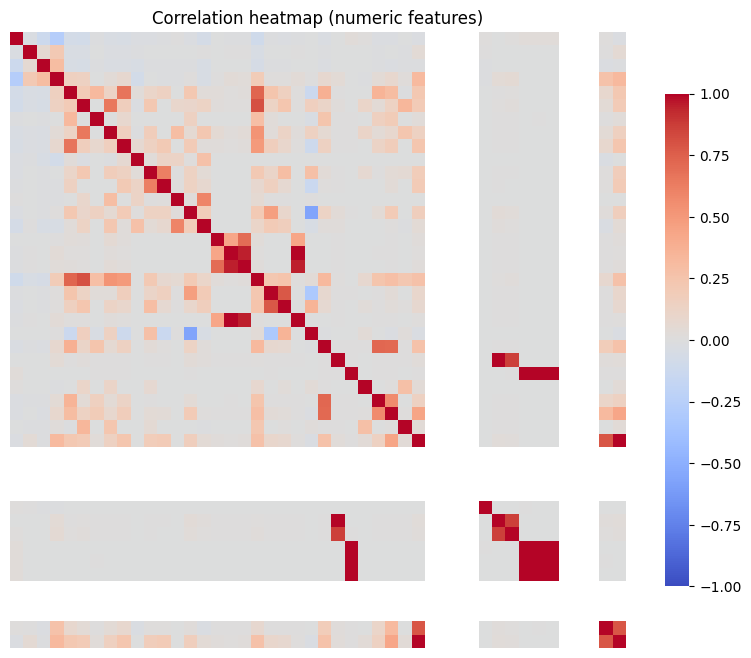


===== Признаки с нулевой дисперсией (n=7) =====
[' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx', ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract']

===== Распределение FLAG =====


FLAG
0    77.86
1    22.14
Name: %, dtype: float64

In [9]:
# === @title Этап 3: первичный анализ и инвентаризация признаков ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

# 0) Копируем исходный df (на всякий случай)
df_eda = df.copy()

# 1) Удаляем служебные колонки, если есть
svc_cols = ["Unnamed: 0", "Index"]
df_eda.drop(columns=[c for c in svc_cols if c in df_eda.columns],
            inplace=True, errors="ignore")

print("==> Shape после удаления служебных колонок:", df_eda.shape)

# 2) Проверяем пропуски
na_counts = df_eda.isna().sum()
na_nonzero = na_counts[na_counts > 0].sort_values(ascending=False)

print("\n===== ТОП-10 столбцов по числу NaN =====")
display(na_nonzero.head(10))

# 3) Корреляционная матрица Пирсона
num_cols = df_eda.select_dtypes(include=[np.number]).columns.tolist()
corr = df_eda[num_cols].corr(method="pearson")

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0,
            vmax=1, vmin=-1, square=True,
            cbar_kws={"shrink": .8}, xticklabels=False, yticklabels=False)
plt.title("Correlation heatmap (numeric features)")
plt.show()

# 4) Признаки с нулевой дисперсией (постоянные значения)
zero_var = df_eda[num_cols].loc[:, df_eda[num_cols].nunique() == 1].columns.tolist()
print(f"\n===== Признаки с нулевой дисперсией (n={len(zero_var)}) =====")
print(zero_var)

# 5) Быстрый взгляд на распределение классов (FLAG)
print("\n===== Распределение FLAG =====")
display(df_eda["FLAG"].value_counts(normalize=True).rename("%").mul(100).round(2))

In [10]:
# === @title Этап 4: очистка признаков перед обучением ===

import pandas as pd, numpy as np

# 0) Копируем исходный df
df_clean = df.copy()

# 1) Убираем пробелы в заголовках и служебные поля
df_clean.columns = df_clean.columns.str.strip()
df_clean.drop(columns=["Unnamed: 0", "Index"], inplace=True, errors="ignore")

# 2) Удаляем все строковые столбцы (Address, токены и т.п.)
str_cols = df_clean.select_dtypes(include=["object"]).columns.tolist()
print("Удаляю строковые колонки:", str_cols)
df_clean = df_clean.drop(columns=str_cols)

# 3) Удаляем признаки с нулевой дисперсией
zero_var = [
    "ERC20 avg time between sent tnx",
    "ERC20 avg time between rec tnx",
    "ERC20 avg time between rec 2 tnx",
    "ERC20 avg time between contract tnx",
    "ERC20 min val sent contract",
    "ERC20 max val sent contract",
    "ERC20 avg val sent contract",
]
to_drop = [c for c in zero_var if c in df_clean.columns]
print("Удаляю zero-variance:", to_drop)
df_clean = df_clean.drop(columns=to_drop)

# 4) Заполняем все NaN медианой по столбцу
num_cols = df_clean.columns.tolist()  # теперь все — числовые
for col in num_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

# 5) Убираем одну из пары сильнокоррелирующих признаков (|ρ| > 0.9)
corr = df_clean.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
print("Удаляю сильно коррелирующие (>0.9):", high_corr_drop)
df_clean = df_clean.drop(columns=high_corr_drop)

# 6) Финальная проверка
print("\nИтоговая форма df_clean:", df_clean.shape)
print("Осталось NaN всего:", df_clean.isna().sum().sum())

Удаляю строковые колонки: ['Address', 'ERC20 most sent token type', 'ERC20_most_rec_token_type']
Удаляю zero-variance: ['ERC20 avg time between sent tnx', 'ERC20 avg time between rec tnx', 'ERC20 avg time between rec 2 tnx', 'ERC20 avg time between contract tnx', 'ERC20 min val sent contract', 'ERC20 max val sent contract', 'ERC20 avg val sent contract']
Удаляю сильно коррелирующие (>0.9): ['avg value sent to contract', 'total ether sent contracts', 'ERC20 max val rec', 'ERC20 min val sent', 'ERC20 max val sent', 'ERC20 avg val sent', 'ERC20 uniq rec token name']

Итоговая форма df_clean: (9841, 32)
Осталось NaN всего: 0


In [11]:
# === @title Этап 5: разделение и SMOTE ===
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# 1) Готовим X и y
SEED = 42
X = df_clean.drop(columns=["FLAG"])
y = df_clean["FLAG"]

# 2) Разбиваем на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# 3) Распределение до SMOTE
print(">> До SMOTE (train):")
print(y_train.value_counts(), "\n")

# 4) Применяем SMOTE
smote = SMOTE(random_state=SEED)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 5) Распределение после SMOTE
print(">> После SMOTE (train_resampled):")
print(y_train_res.value_counts())

>> До SMOTE (train):
FLAG
0    6129
1    1743
Name: count, dtype: int64 

>> После SMOTE (train_resampled):
FLAG
0    6129
1    6129
Name: count, dtype: int64


In [12]:
# === @title Этап 6 (исправленный): масштабирование признаков на всём датасете ===
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 1) Подготовка: берём все числовые признаки (кроме метки FLAG)
X_full = df_clean.drop(columns=["FLAG"]).values

# 2) Инициализируем и подгоняем scaler на всём X_full
scaler = MinMaxScaler()
scaler.fit(X_full)

# 3) Преобразуем тренировочные и тестовые данные
X_train_scaled = scaler.transform(X_train_res)  # resampled train
X_test_scaled  = scaler.transform(X_test)       # original test

# 4) Проверка диапазонов
print("== X_train_scaled ==")
print("min:", np.min(X_train_scaled), " max:", np.max(X_train_scaled))
print("shape:", X_train_scaled.shape)

print("\n== X_test_scaled ==")
print("min:", np.min(X_test_scaled), " max:", np.max(X_test_scaled))
print("shape:", X_test_scaled.shape)

== X_train_scaled ==
min: 0.0  max: 1.0
shape: (12258, 31)

== X_test_scaled ==
min: 0.0  max: 1.0
shape: (1969, 31)


/Users/a1234/Fraud/.venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/Users/a1234/Fraud/.venv/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [13]:
# === @title Этап 7: подготовка данных для LSTM ===
import numpy as np

# 1) Форма для LSTM: (samples, timesteps=1, features)
n_features = X_train_scaled.shape[1]

X_train_lstm = X_train_scaled.reshape(-1, 1, n_features)
X_test_lstm  = X_test_scaled.reshape(-1, 1, n_features)

# 2) Целевые массивы
y_train_lstm = y_train_res.values if hasattr(y_train_res, "values") else np.array(y_train_res)
y_test_lstm  = y_test.values       if hasattr(y_test, "values")  else np.array(y_test)

# 3) Отладочная информация
print("X_train_lstm shape:", X_train_lstm.shape)
print("X_test_lstm  shape:", X_test_lstm.shape)
print("y_train_lstm shape:", y_train_lstm.shape)
print("y_test_lstm  shape:", y_test_lstm.shape)

X_train_lstm shape: (12258, 1, 31)
X_test_lstm  shape: (1969, 1, 31)
y_train_lstm shape: (12258,)
y_test_lstm  shape: (1969,)


In [14]:
# === @title Этап 8: построение LSTM-модели ===
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1) Создаём модель
model = Sequential([
    LSTM(64, input_shape=(1, X_train_lstm.shape[2])),  # timesteps=1, features=n_features
    Dense(1, activation='sigmoid')
])

# 2) Компиляция
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 3) Вывод структуры модели
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                24576     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 24641 (96.25 KB)
Trainable params: 24641 (96.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/200
154/154 - 1s - loss: 0.6586 - accuracy: 0.6180 - val_loss: 0.9449 - val_accuracy: 0.0000e+00 - 1s/epoch - 7ms/step
Epoch 2/200
154/154 - 0s - loss: 0.6186 - accuracy: 0.6250 - val_loss: 0.8609 - val_accuracy: 0.0000e+00 - 176ms/epoch - 1ms/step
Epoch 3/200
154/154 - 0s - loss: 0.5860 - accuracy: 0.6257 - val_loss: 0.8250 - val_accuracy: 4.0783e-04 - 172ms/epoch - 1ms/step
Epoch 4/200
154/154 - 0s - loss: 0.5687 - accuracy: 0.6502 - val_loss: 0.8339 - val_accuracy: 0.3458 - 171ms/epoch - 1ms/step
Epoch 5/200
154/154 - 0s - loss: 0.5606 - accuracy: 0.6777 - val_loss: 0.8289 - val_accuracy: 0.5420 - 165ms/epoch - 1ms/step
Epoch 6/200
154/154 - 0s - loss: 0.5572 - accuracy: 0.6802 - val_loss: 0.7668 - val_accuracy: 0.7268 - 173ms/epoch - 1ms/step
Epoch 7/200
154/154 - 0s - loss: 0.5551 - accuracy: 0.6840 - val_loss: 0.7397 - val_accuracy: 0.7696 - 174ms/epoch - 1ms/step
Epoch 8/200
154/154 - 0s - loss: 0.5534 - accuracy: 0.6789 - val_loss: 0.7355 - val_accuracy: 0.7785 - 171ms/

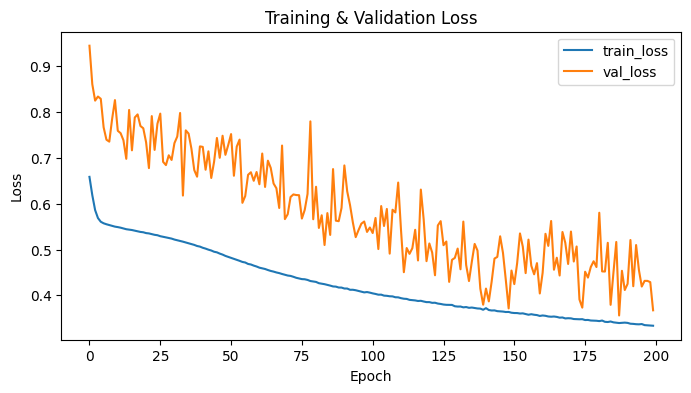

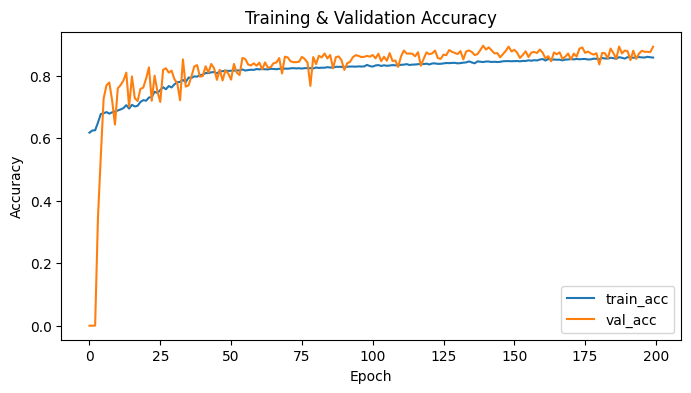

Final train_acc: 0.8586
Final val_acc:   0.8931


In [16]:
# === @title Этап 9: обучение LSTM-модели ===
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Параметры обучения
epochs = 200
batch_size = 64

# Запуск обучения
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.20,
    shuffle=True,
    verbose=2
)

# --- Отладочные графики ---

# 1) Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],    label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2) Accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'],    label='train_acc')
plt.plot(history.history['val_accuracy'],label='val_acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 3) Финальные метрики
print(f"Final train_acc: {history.history['accuracy'][-1]:.4f}")
print(f"Final val_acc:   {history.history['val_accuracy'][-1]:.4f}")

In [17]:
# === @title Этап 10: оценка модели на тесте ===
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1) Предсказания
y_pred_proba = model.predict(X_test_lstm, verbose=0)
y_pred = (y_pred_proba >= 0.5).astype(int).flatten()

# 2) Метрики
acc   = accuracy_score(y_test_lstm, y_pred)
prec  = precision_score(y_test_lstm, y_pred)
rec   = recall_score(y_test_lstm, y_pred)
f1    = f1_score(y_test_lstm, y_pred)
cm    = confusion_matrix(y_test_lstm, y_pred)

# 3) Вывод результатов
print("=== Test Metrics ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}\n")

print("=== Confusion Matrix ===")
print(cm)

=== Test Metrics ===
Accuracy : 0.8461
Precision: 0.6054
Recall   : 0.8761
F1-score : 0.7160

=== Confusion Matrix ===
[[1284  249]
 [  54  382]]


In [18]:
# Шаг 1: Настройка callback для сохранения лучших весов
from tensorflow.keras.callbacks import ModelCheckpoint

# Создаём папку для чекпойнтов, если её ещё нет
os.makedirs("checkpoints", exist_ok=True)

# Путь для сохранения лучших весов
checkpoint_path = "checkpoints/lstm_best_weights.h5"

# Callback для сохранения только лучших весов на основе 'val_loss'
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',       # Следим за валидационной метрикой
    save_best_only=True,      # Сохраняем только лучшие веса
    mode='min',               # Минимизируем метрику (например, для val_loss)
    verbose=1,                # Печать, когда сохраняется
    save_freq='epoch'        # Сохраняем после каждой эпохи
)

# Шаг 2: Обучение модели с использованием этого колбэка
history = model.fit(
    X_train_lstm, y_train_lstm,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=0.20,
    shuffle=True,
    callbacks=[cp_callback],  # Добавляем колбэк
    verbose=2
)

# Шаг 3: Сохранение модели целиком и веса
import pickle
from pathlib import Path

# 1) Создаём папку для артефактов
artifacts_dir = Path("artifacts")
artifacts_dir.mkdir(exist_ok=True)

# 2) Сохраняем модель целиком (архитектура + веса)
model_path = artifacts_dir / "lstm_eth_fraud_model.h5"
model.save(str(model_path))
print(f"Модель сохранена в {model_path}")

# 3) Сохраняем scaler
scaler_path = artifacts_dir / "scaler.pkl"
with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)
print(f"Scaler сохранён в {scaler_path}")

# 4) Сохраняем список признаков (чтобы при загрузке знать порядок столбцов)
feature_list = X.columns.tolist()  # X – до разбиения, без FLAG
features_path = artifacts_dir / "features_list.pkl"
with open(features_path, "wb") as f:
    pickle.dump(feature_list, f)
print(f"Список признаков сохранён в {features_path}")

# Шаг 4: Извлечение и сохранение эмбеддингов

# Создаём модель для получения эмбеддингов (например, из первого LSTM слоя)
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.layers[0].output)

# Извлекаем эмбеддинги для тренировочных и тестовых данных
embeddings_train = embedding_model.predict(X_train_lstm)
embeddings_test = embedding_model.predict(X_test_lstm)

# Сохраняем эмбеддинги
np.save("artifacts/embeddings_train.npy", embeddings_train)
np.save("artifacts/embeddings_test.npy", embeddings_test)
print(f"Эмбеддинги сохранены в 'artifacts/embeddings_train.npy' и 'artifacts/embeddings_test.npy'")

# Шаг 5: Проверка воспроизводимости (если необходимо)
# Загружаем модель и другие артефакты
model = tf.keras.models.load_model(str(artifacts_dir / "lstm_eth_fraud_model.h5"))
with open(artifacts_dir / "scaler.pkl", "rb") as f:
    scaler = pickle.load(f)
with open(artifacts_dir / "features_list.pkl", "rb") as f:
    features_list = pickle.load(f)

# Загружаем эмбеддинги (если нужно)
embeddings_train = np.load("artifacts/embeddings_train.npy")
embeddings_test = np.load("artifacts/embeddings_test.npy")

print("Эмбеддинги и модель успешно загружены для дальнейшего использования.")


Epoch 1/200

Epoch 1: val_loss improved from inf to 0.39180, saving model to checkpoints/lstm_best_weights.h5
154/154 - 0s - loss: 0.3335 - accuracy: 0.8597 - val_loss: 0.3918 - val_accuracy: 0.8870 - 224ms/epoch - 1ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.39180
154/154 - 0s - loss: 0.3336 - accuracy: 0.8623 - val_loss: 0.4139 - val_accuracy: 0.8821 - 176ms/epoch - 1ms/step
Epoch 3/200


/Users/a1234/Fraud/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_loss improved from 0.39180 to 0.38680, saving model to checkpoints/lstm_best_weights.h5
154/154 - 0s - loss: 0.3323 - accuracy: 0.8625 - val_loss: 0.3868 - val_accuracy: 0.8899 - 172ms/epoch - 1ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.38680
154/154 - 0s - loss: 0.3318 - accuracy: 0.8644 - val_loss: 0.4024 - val_accuracy: 0.8813 - 175ms/epoch - 1ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.38680
154/154 - 0s - loss: 0.3314 - accuracy: 0.8623 - val_loss: 0.4354 - val_accuracy: 0.8740 - 166ms/epoch - 1ms/step
Epoch 6/200

Epoch 6: val_loss did not improve from 0.38680
154/154 - 0s - loss: 0.3311 - accuracy: 0.8604 - val_loss: 0.4332 - val_accuracy: 0.8760 - 167ms/epoch - 1ms/step
Epoch 7/200

Epoch 7: val_loss did not improve from 0.38680
154/154 - 0s - loss: 0.3307 - accuracy: 0.8648 - val_loss: 0.5059 - val_accuracy: 0.8544 - 181ms/epoch - 1ms/step
Epoch 8/200

Epoch 8: val_loss did not improve from 0.38680
154/154 - 0s - loss: 0.3299 